In [1]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time

## Data from chatept with electra

In [2]:
chatept_output = pd.read_pickle("ChatEPT/chatept_output")

## Data from chatept with prompt2

In [3]:
chatept_output_prompt2 = pd.read_pickle("ChatEPT/prompt2/chatept_output")

In [6]:
chatept_output["prompt2_chatgpt_response_emotion"] = chatept_output_prompt2["prompt2_chatgpt_response_emotion"]
chatept_output["chatgpt_response_prompt2"] = chatept_output_prompt2["chatgpt_response_prompt2"]
chatept_output.head()

,index,conv_id,context,utterance,utterance_minus_2_emotion,utterance_minus_2_emotion_conf,chatgpt_response_no_emotion,chatgpt_emotional_response,no_emotion_chatgpt_response_emotion,emotional_chatgpt_response_emotion,prompt2_chatgpt_response_emotion,chatgpt_response_prompt2
0,0,hit:0_conv:1,sentimental,[I remember going to see the fireworks with my...,neutral,99.86,I'm sorry to hear that. It's tough losing a go...,"(neutral, 99.86, I'm sorry to hear that. Losin...","(grief, 55.02)","(sadness, 97.31)","(sadness, 98.62)",I can imagine that losing a close friend can b...
1,1,hit:10000_conv:20000,surprised,"[My girlfriend got me a pet toad today!, Do yo...",joy,98.35,That's great to hear! Toads can make wonderful...,"(joy, 98.35, That's great to hear! Toads can m...","(admiration, 90.69)","(admiration, 85.92)","(joy, 97.68)","As an AI language model, I don't have feelings..."
2,2,hit:10000_conv:20001,impressed,"[I really like the new paint job on my house.,...",neutral,91.12,That sounds like a beautiful combination of co...,"(neutral, 91.12, Blue and yellow is a lovely c...","(admiration, 90.89)","(love, 94.29)","(admiration, 73.85)",I'm glad to hear that you're happy with the ne...
3,3,hit:10001_conv:20002,lonely,[I went to the skating rink all by myself toda...,disappointment,31.49,I'm sorry to hear that. It's tough to feel lef...,"(disappointment, 31.49, I'm sorry to hear that...","(remorse, 82.51)","(optimism, 70.82)","(sadness, 82.12)",I'm sorry you had a bad time. It's tough to fe...
4,4,hit:10002_conv:20004,ashamed,[I was walking on the road. I saw a beggar and...,embarrassment,99.49,It's never too late to help someone in need. N...,"(embarrassment, 99.49, That's completely under...","(caring, 94.53)","(approval, 57.74)","(approval, 97.07)","It's understandable that you were in a rush, b..."


In [7]:
outputs_df = chatept_output[["conv_id", "utterance_minus_2_emotion", "no_emotion_chatgpt_response_emotion", "emotional_chatgpt_response_emotion", "prompt2_chatgpt_response_emotion"]]
outputs_df = outputs_df.rename(columns={"conv_id": "conv_id", 'no_emotion_chatgpt_response_emotion': 'non_emotional', 'emotional_chatgpt_response_emotion': 'emotional', 'prompt2_chatgpt_response_emotion': 'prompt2'})

outputs_df[['non_emotional_emotion', 'non_emotional_conf']] = outputs_df['non_emotional'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('non_emotional', axis=1)

outputs_df[['emotional_emotion', 'emotional_conf']] = outputs_df['emotional'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('emotional', axis=1)

outputs_df[['prompt2_emotion', 'prompt2_conf']] = outputs_df['prompt2'].apply(lambda x: pd.Series(x))
outputs_df = outputs_df.drop('prompt2', axis=1)

outputs_df.head()

,conv_id,utterance_minus_2_emotion,non_emotional_emotion,non_emotional_conf,emotional_emotion,emotional_conf,prompt2_emotion,prompt2_conf
0,hit:0_conv:1,neutral,grief,55.02,sadness,97.31,sadness,98.62
1,hit:10000_conv:20000,joy,admiration,90.69,admiration,85.92,joy,97.68
2,hit:10000_conv:20001,neutral,admiration,90.89,love,94.29,admiration,73.85
3,hit:10001_conv:20002,disappointment,remorse,82.51,optimism,70.82,sadness,82.12
4,hit:10002_conv:20004,embarrassment,caring,94.53,approval,57.74,approval,97.07


In [13]:
emotion_dict = {'admiration': 'positive', 'amusement': 'positive', 'anger': 'negative', 'annoyance': 'negative', 'approval': 'positive', 'caring': 'positive', 'confusion': 'ambiguous', 'curiosity': 'ambiguous', 'desire': 'positive', 'disappointment': 'negative', 'disapproval': 'negative', 'disgust': 'negative', 'embarrassment': 'negative', 'excitement': 'positive', 'fear': 'negative', 'gratitude': 'positive', 'grief': 'negative', 'joy': 'positive', 'love': 'positive', 'nervousness': 'negative', 'optimism': 'positive', 'pride': 'positive', 'realization': 'ambiguous', 'relief': 'positive', 'remorse': 'negative', 'sadness': 'negative', 'surprise': 'ambiguous', 'neutral': 'neutral'}
emotion_colors_dict = {"positive": "green", "negative": "red", "ambiguous": "orange", "neutral": "gray"}
emotion_to_color_dict = {emotion: emotion_colors_dict[emotion_dict[emotion]] for emotion in emotion_dict}

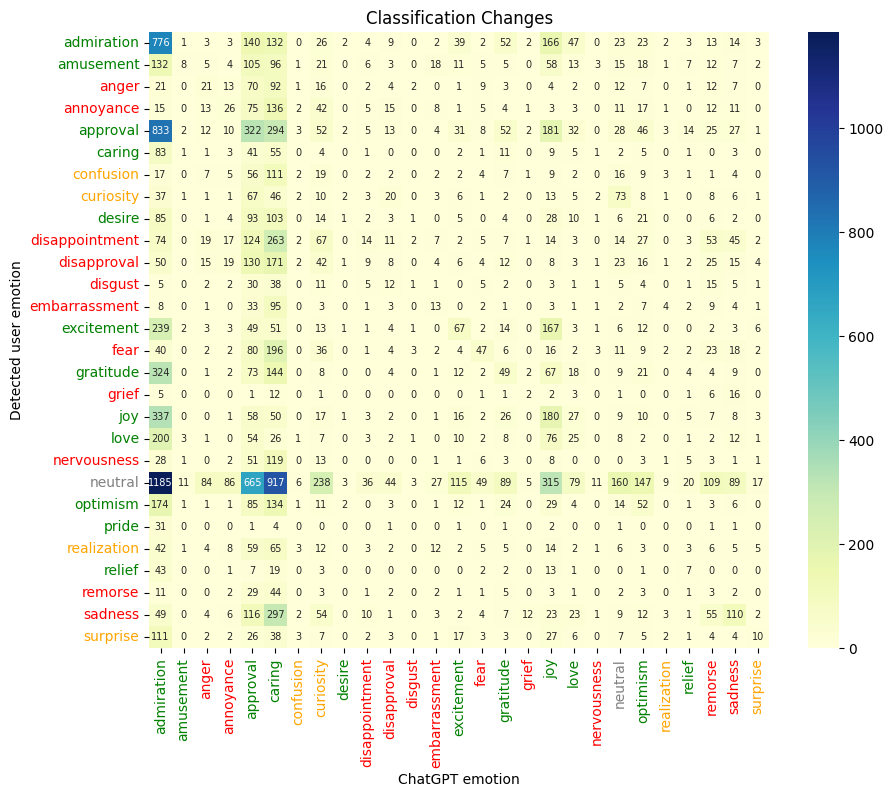

In [14]:
# Create two sample Series
s1 = chatept_output.utterance_minus_2_emotion
s2 = outputs_df.non_emotional_emotion

# Create a crosstab of the two Series
crosstab_non_emotional = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(10,8))
sns.heatmap(crosstab_non_emotional, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})

# Get the ytick labels
ytick_labels = plt.gca().get_yticklabels()

# Set the color for each ytick label
label_colors = [emotion_to_color_dict[emotion] for emotion in crosstab_non_emotional.index.to_list()]
for i, label in enumerate(ytick_labels):
    label.set_color(label_colors[i])
    
# Get the xtick labels
xtick_labels = plt.gca().get_xticklabels()

# Set the color for each xtick label
xlabel_colors = [emotion_to_color_dict[emotion] for emotion in crosstab_non_emotional.columns.to_list()]
for i, label in enumerate(xtick_labels):
    label.set_color(xlabel_colors[i])

plt.xlabel('ChatGPT emotion')
plt.ylabel('Detected user emotion')
plt.title('Classification Changes')
plt.show()

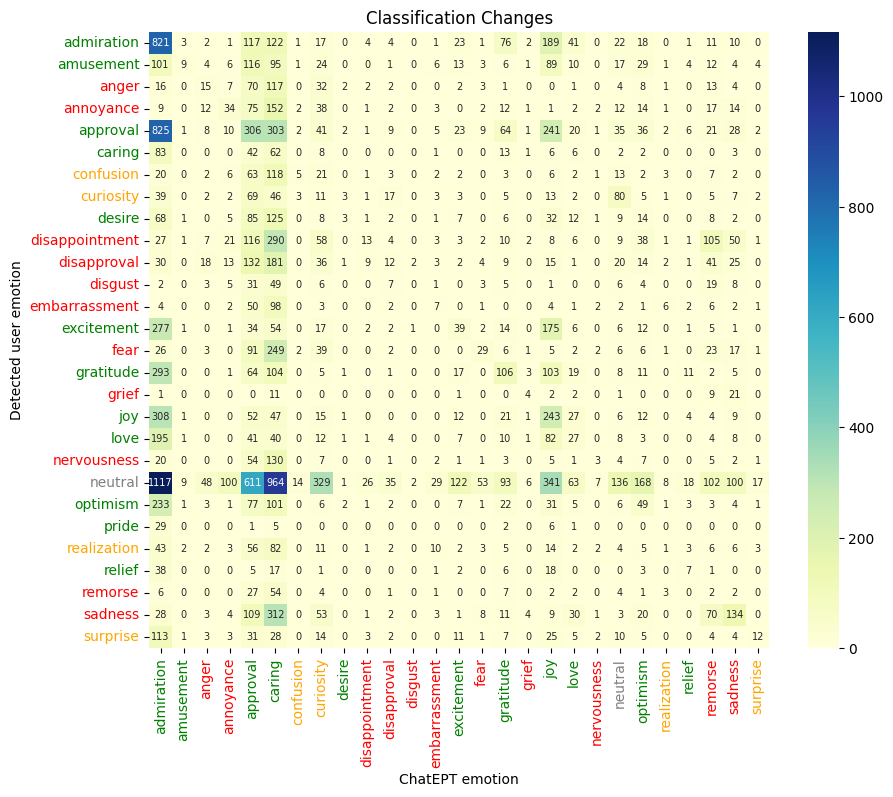

In [15]:
# Create two sample Series
s1 = chatept_output.utterance_minus_2_emotion
s2 = outputs_df.emotional_emotion

# Create a crosstab of the two Series
crosstab_emotional = pd.crosstab(s1, s2)

# Create a heatmap of the crosstab
plt.figure(figsize=(10,8))
sns.heatmap(crosstab_emotional, annot=True, cmap='YlGnBu', fmt='.0f', annot_kws={'fontsize':7})

# Get the ytick labels
ytick_labels = plt.gca().get_yticklabels()

# Set the color for each ytick label
label_colors = [emotion_to_color_dict[emotion] for emotion in crosstab_emotional.index.to_list()]
for i, label in enumerate(ytick_labels):
    label.set_color(label_colors[i])
    
# Get the xtick labels
xtick_labels = plt.gca().get_xticklabels()

# Set the color for each xtick label
xlabel_colors = [emotion_to_color_dict[emotion] for emotion in crosstab_emotional.columns.to_list()]
for i, label in enumerate(xtick_labels):
    label.set_color(xlabel_colors[i])

plt.xlabel('ChatEPT emotion')
plt.ylabel('Detected user emotion')
plt.title('Classification Changes')
plt.show()

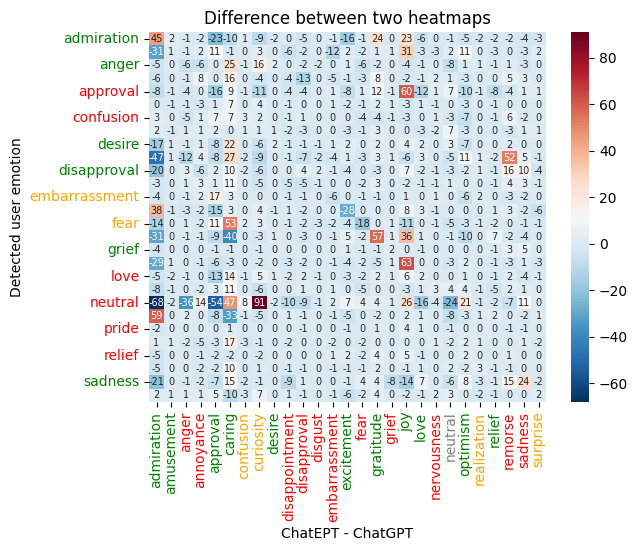

In [16]:
# Compute the difference between the two heatmaps
heatmap_diff = crosstab_emotional - crosstab_non_emotional

# Plot the difference heatmap
#plt.imshow(heatmap_diff, cmap='RdBu_r')
vmin = heatmap_diff.min().min()
vmax = heatmap_diff.max().max()
ticks = [vmax, (vmax + vmin) / 2, vmin]


sns.heatmap(heatmap_diff, annot=True, cmap='RdBu_r', fmt='.0f', annot_kws={'fontsize':7})

# Get the ytick labels
ytick_labels = plt.gca().get_yticklabels()

# Set the color for each ytick label
label_colors = [emotion_to_color_dict[emotion] for emotion in heatmap_diff.index.to_list()]
for i, label in enumerate(ytick_labels):
    label.set_color(label_colors[i])
    
# Get the xtick labels
xtick_labels = plt.gca().get_xticklabels()

# Set the color for each xtick label
xlabel_colors = [emotion_to_color_dict[emotion] for emotion in heatmap_diff.columns.to_list()]
for i, label in enumerate(xtick_labels):
    label.set_color(xlabel_colors[i])

# Add a colorbar and title
#plt.colorbar()
plt.xlabel('ChatEPT - ChatGPT')
plt.ylabel('Detected user emotion')
plt.title('Difference between two heatmaps')

# Show the plot
plt.show()

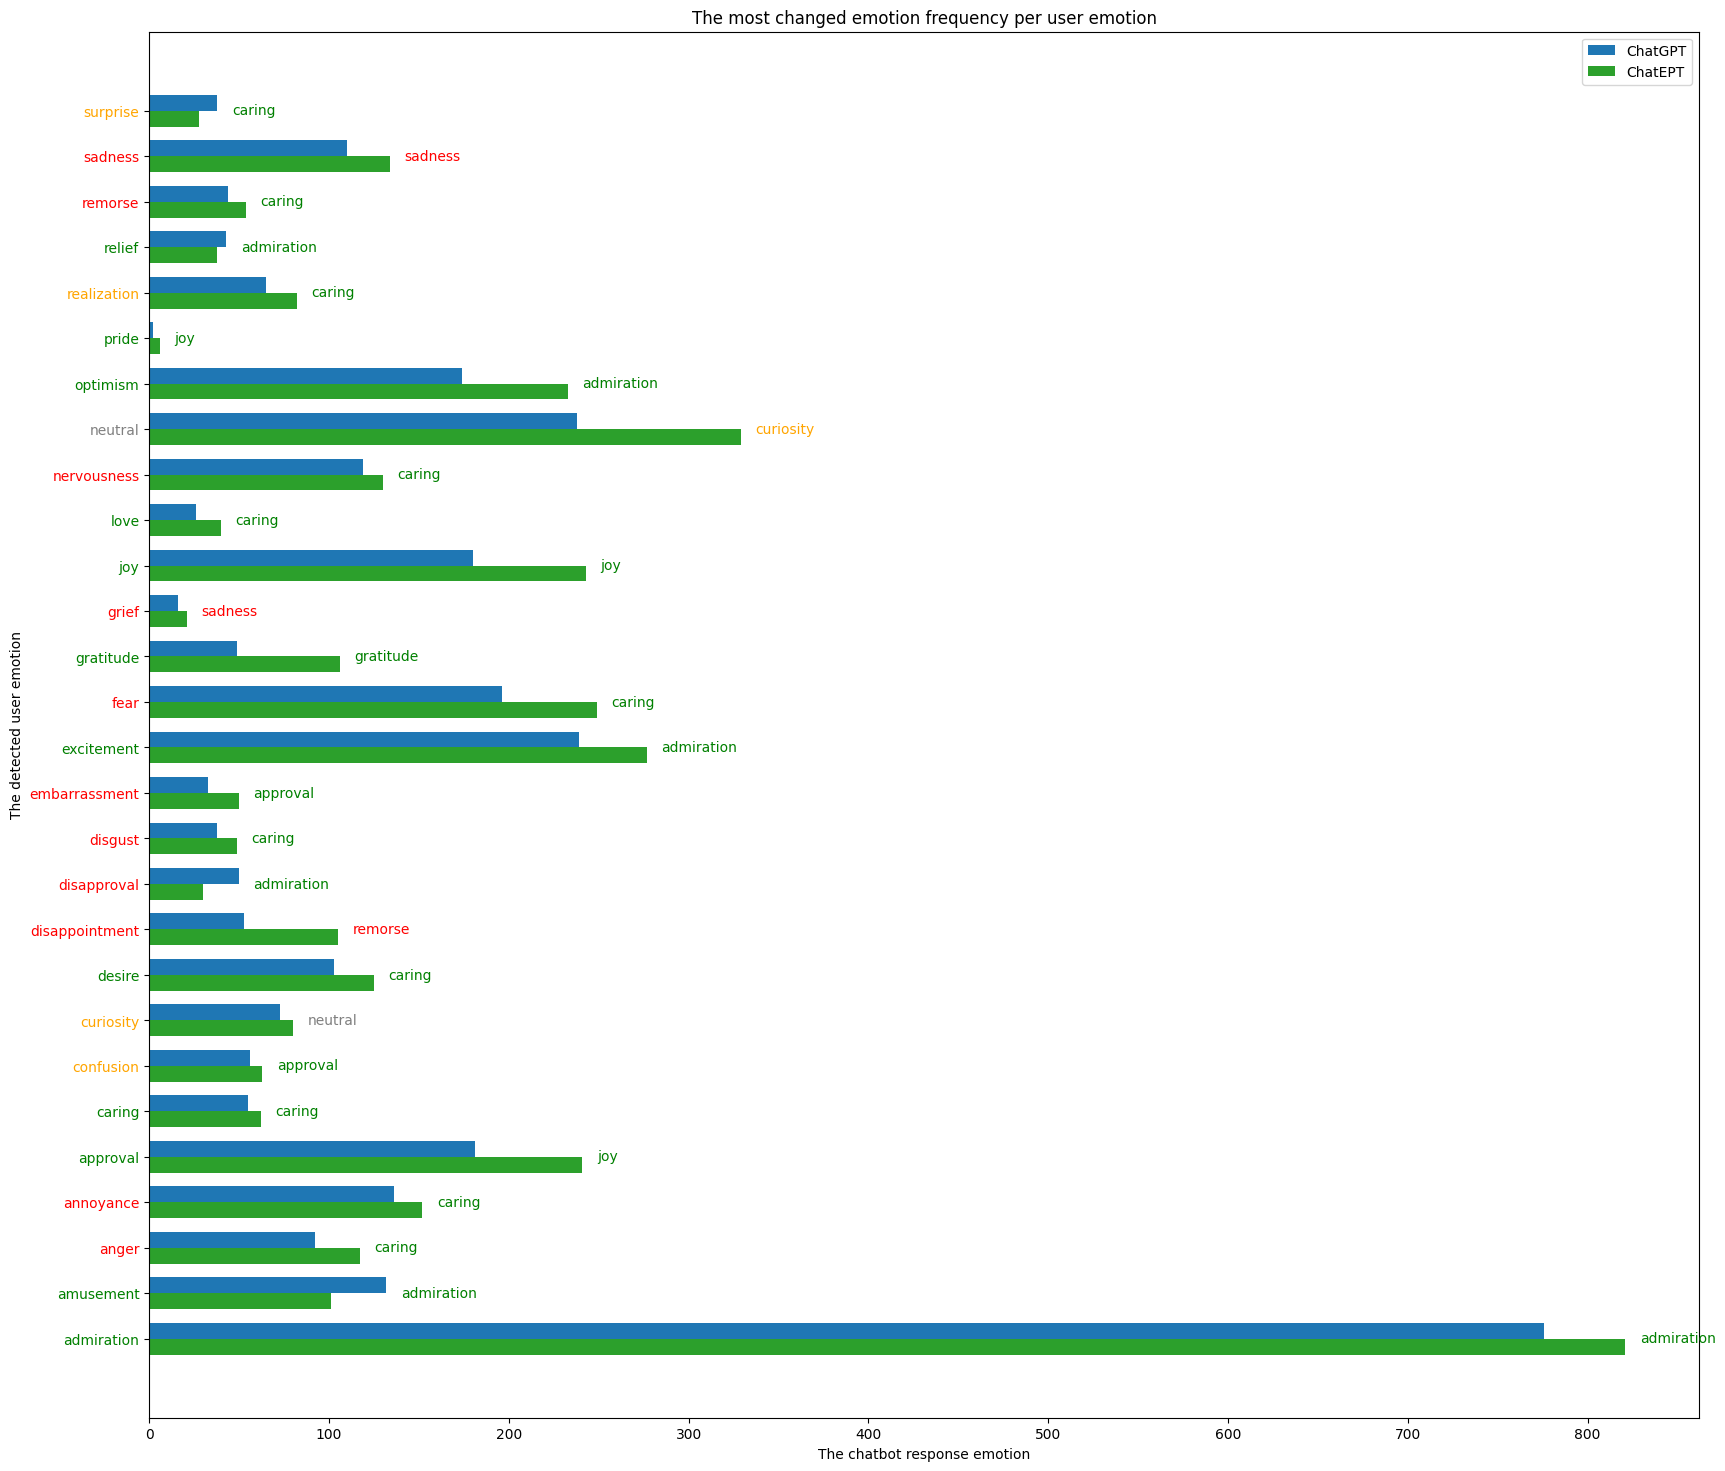

In [17]:
max_absolute_values = heatmap_diff.abs().max(axis=1)
max_column_names = heatmap_diff.abs().idxmax(axis=1)

biggest_emo_freq_diff = []
chatgpt_freq = []
chatept_freq = []
for i, user_emotion in enumerate(heatmap_diff.index.to_list()):
    chatgpt_freq.append(crosstab_non_emotional.loc[user_emotion, max_column_names.to_list()[i]])
    chatept_freq.append(crosstab_emotional.loc[user_emotion, max_column_names.to_list()[i]])
    biggest_emo_freq_diff.append(heatmap_diff.loc[user_emotion, max_column_names.to_list()[i]])

plt.figure(figsize=(20, 18))    
# Define the x-axis range
x_range = np.arange(len(heatmap_diff.index.to_list()))

# Define the width of the bars
bar_width = 0.35

# Plot the bars for chatgpt_freq
plt.barh(x_range + bar_width, chatgpt_freq, height=bar_width, label='ChatGPT')

# Plot the bars for chatept_freq
plt.barh(x_range, chatept_freq, height=bar_width, label='ChatEPT', color="#2ca02c")

# Set the x-axis labels
plt.yticks(x_range + bar_width / 2, heatmap_diff.index.to_list())

for i, (cg_freq, ce_freq) in enumerate(zip(chatgpt_freq, chatept_freq)):
    plt.text(max(cg_freq, ce_freq)+8 , i + bar_width / 2, f"{max_column_names.to_list()[i]}", color=emotion_to_color_dict[max_column_names.to_list()[i]], va="center")

# Get the ytick labels
ytick_labels = plt.gca().get_yticklabels()

# Set the color for each ytick label
label_colors = [emotion_to_color_dict[emotion] for emotion in heatmap_diff.index.to_list()]
for i, label in enumerate(ytick_labels):
    label.set_color(label_colors[i])
    
# Add a legend
plt.legend()

# Add a title
plt.title("The most changed emotion frequency per user emotion")
plt.xlabel("The chatbot response emotion")
plt.ylabel("The detected user emotion")
# Show the plot
plt.show()